In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils.validation import column_or_1d
from sklearn.model_selection import cross_val_score, cross_validate 
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('cardio_train.csv' , sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# Cleaning Data

In [3]:
df.isnull().values.any()
#No null values

False

In [4]:
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)
#Height and weight consists of outliers. Hence dropping the values before 0.025 and 0.975

Diastilic pressure is higher than systolic one in 1082 cases


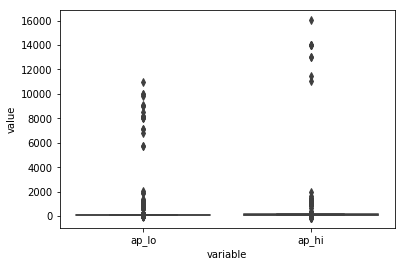

In [5]:
blood_pressure = df.loc[:,['ap_lo','ap_hi']]
sns.boxplot(x = 'variable',y = 'value',data = blood_pressure.melt())
print("Diastilic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

In [6]:
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)
#Dropping values where diastolic pressure is higher than systolic pressure

Diastilic pressure is higher than systolic one in 0 cases


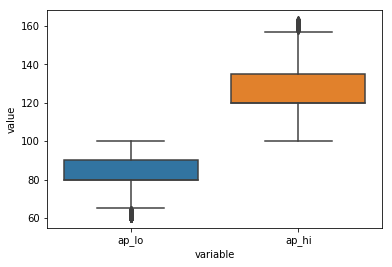

In [7]:
blood_pressure = df.loc[:,['ap_lo','ap_hi']]
sns.boxplot(x = 'variable',y = 'value',data = blood_pressure.melt())
print("Diastilic pressure is higher than systolic one in {0} cases".format(df[df['ap_lo']> df['ap_hi']].shape[0]))

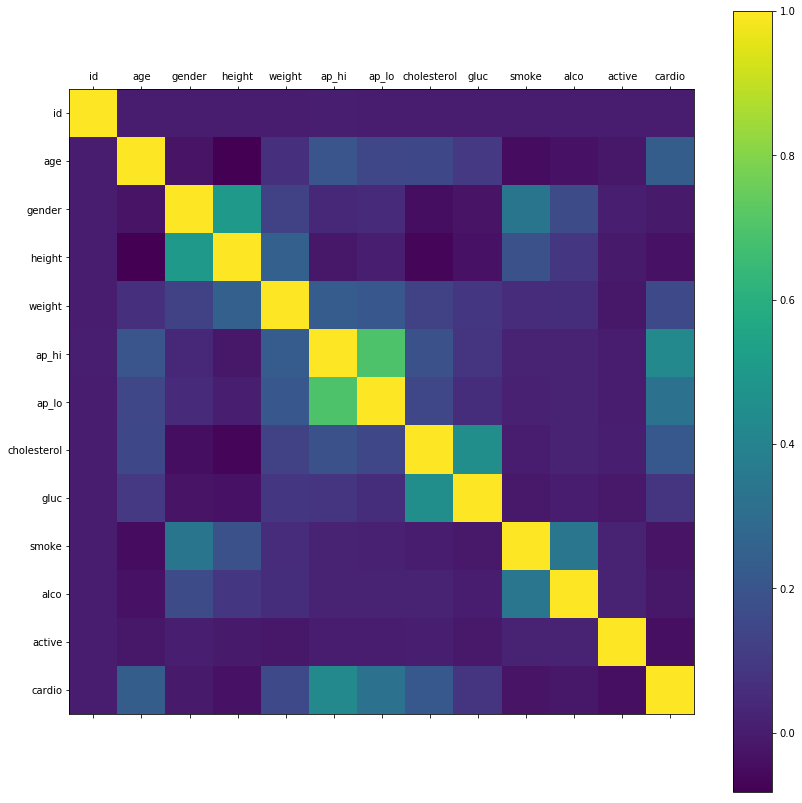

In [8]:
rcParams['figure.figsize'] = 20, 14
plt.matshow(df.corr())
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.xticks(np.arange(df.shape[1]), df.columns)
plt.colorbar()

#Correlation matrix gives an idea on the correlation of features 

In [9]:
#converted age to years for readability
df['age'] = round((df['age']/365))
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.0,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.0,1,156,85.0,140,90,3,1,0,0,1,1
2,2,52.0,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.0,2,169,82.0,150,100,1,1,0,0,1,1
4,4,48.0,1,156,56.0,100,60,1,1,0,0,0,0


# Predicting Cardio Vascular

### Using Decision Tree

In [10]:
#split data into featureed and what we are trying to predict
feature_cols = ['age', 'gender', 'height', 'weight', 'ap_hi','ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
X = df[feature_cols]
y = df.cardio

In [11]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)

#### Visulaizing The Decision Tree

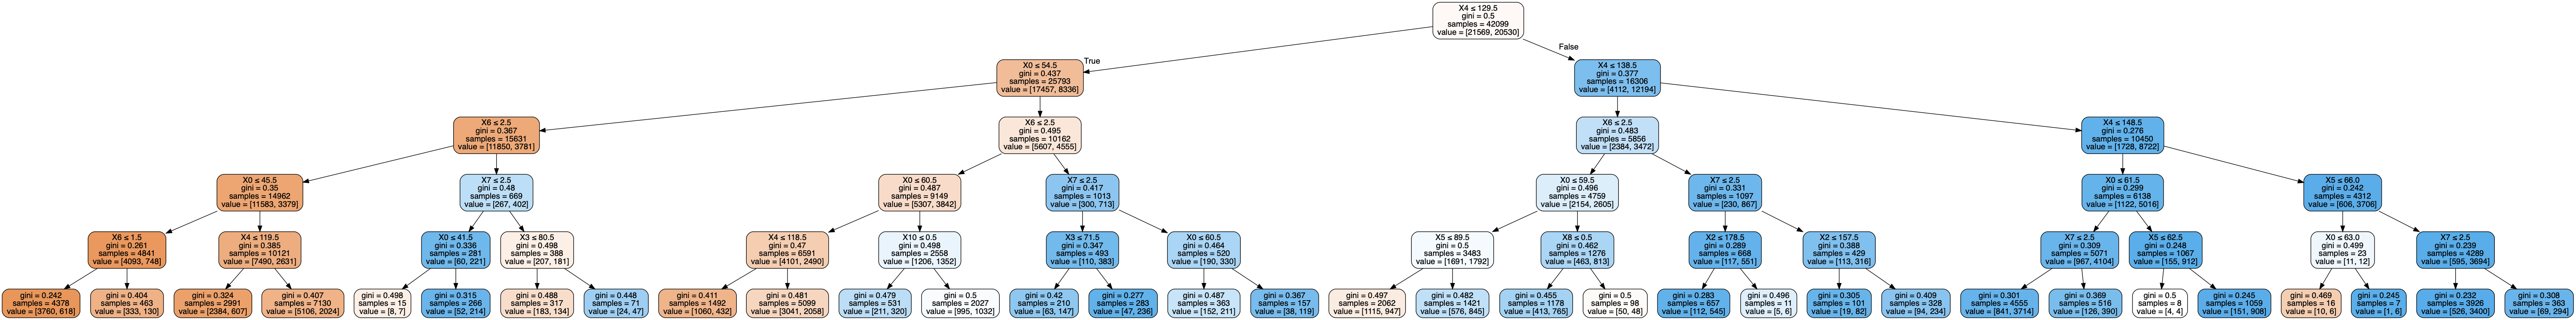

In [12]:
# fit a classification tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
treeclf = DecisionTreeClassifier(max_depth=5, random_state=1)

# Fit our training data
treeclf.fit(Xtrain, ytrain)
dot_data = StringIO()
export_graphviz(treeclf.fit(Xtrain, ytrain), out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
print("Training accuracy: {}".format(accuracy_score(ytrain, treeclf.predict(Xtrain))))
print("Testing accuracy : {}".format(accuracy_score(ytest, treeclf.predict(Xtest))))

Training accuracy: 0.726121760611891
Testing accuracy : 0.7219974505348334


#### Using Cross Validation To Get Average Accuracy 

***10 Folds***

In [14]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(treeclf, Xtrain, ytrain, cv=10, scoring='accuracy')
print("Accuracy for each fold: {}".format(scores))
print("Mean Accuracy: {}".format(np.mean(scores)))

Accuracy for each fold: [0.7263658  0.72589074 0.73111639 0.7192399  0.72660333 0.71852732
 0.7263658  0.72327791 0.72137767 0.72202423]
Mean Accuracy: 0.724078907939045


In [15]:
from sklearn.model_selection import validation_curve

max_depth_range = range(1, 11)

train_scores, valid_scores = validation_curve( treeclf, Xtrain, ytrain, param_name="max_depth", param_range=max_depth_range,
    cv=10, scoring="accuracy")

In [16]:
#Size of train_scores will be: length of parameter (max_depth_range) X number of folds
print(train_scores.shape)

(10, 10)


#### Mean accuracy score for each value of Max-Depth (Visualization)

Text(0.5, 1.0, 'Accuracy comparison of training/validation set')

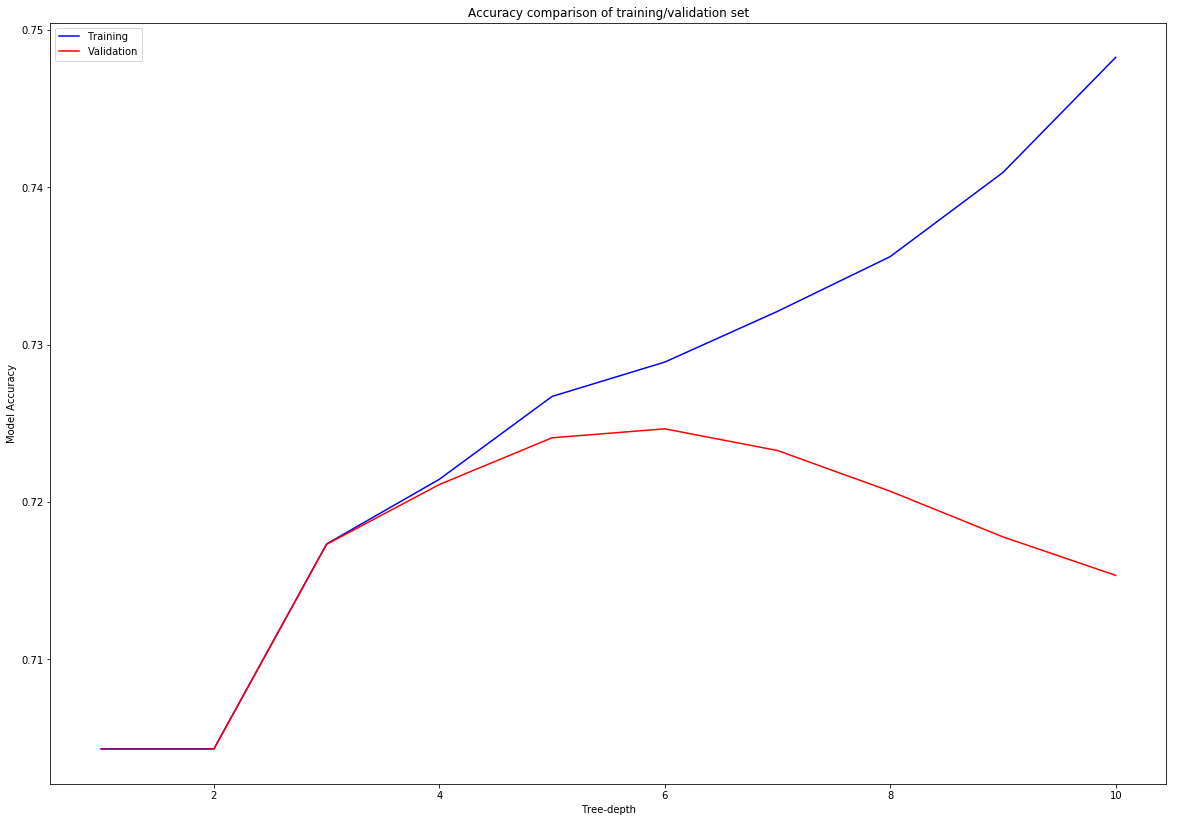

In [17]:
# Mean accuracy score for each value of max-depth
mean_train_score = np.mean(train_scores, axis=1) 
mean_val_score   = np.mean(valid_scores, axis=1)

plt.plot(max_depth_range, mean_train_score, color="blue", linewidth=1.5, label="Training")
plt.plot(max_depth_range, mean_val_score, color="red", linewidth=1.5, label="Validation")
plt.legend(loc="upper left")
plt.xlabel("Tree-depth")
plt.ylabel("Model Accuracy")
plt.title("Accuracy comparison of training/validation set")

### Result

With a rise in tree depth we can notice the decision tree showing overfitting. The best value of max_depth is 6. 

In [18]:
treeclf = DecisionTreeClassifier(max_depth=6)
treeclf.fit(Xtrain,ytrain)
print("Training accuracy: {}".format(accuracy_score(ytrain, treeclf.predict(Xtrain))))
print("Testing accuracy : {}".format(accuracy_score(ytest, treeclf.predict(Xtest))))


Training accuracy: 0.7282595786123186
Testing accuracy : 0.7222191431580114


With changes to the max depth in Decision Tree Classifier we can note there is an increase in the accuracy for training and testing

For our CardioVascular dartaset we are able to predict CVD with other variables through an aproximate 73% accuracy

### Using Linear Regression

We will now be using linear regression to test for CVD

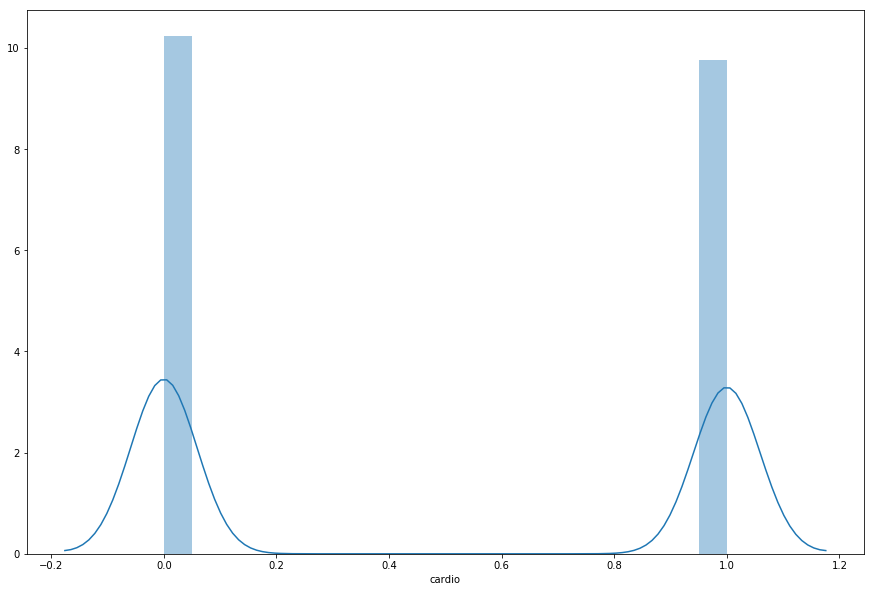

In [19]:
#Check average of CVD
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(df['cardio'])


Between non CVD and CVD it is very close therefore almost equal amount

Furthermore, we will split 80% of our data to training, and 20% for testing

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
regression = LinearRegression()  
regression.fit(X_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Training our data with Linear Regression

In [22]:
pd.DataFrame(regression.coef_, X.columns, columns=['Coefficient'])  

,Coefficient
age,0.010134
gender,-0.003146
height,-0.001160
weight,0.002388
ap_hi,0.012433
ap_lo,0.002023
cholesterol,0.098883
gluc,-0.022528
smoke,-0.028416
alco,-0.044816


Here we can note that the choloestrol category has the biggest impact on CVD whereby Activity levels can decrease the chances of CVD more than any other variables.

In [23]:
y_pred = regression.predict(X_test)

Actual_pred_df_true = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(10)

Actual_pred_df_true 

,Actual,Predicted
34893,1,0.518340
28226,1,0.719372
25265,1,0.473672
16202,0,0.025978
56285,1,0.465274
49198,1,0.497562
45469,1,0.525813
13546,0,0.228969
15336,1,0.636061
64029,0,0.496196


We can observe the actual values compared to predicted values done by the linear regression, Due to the nature of the dataset where CVD is determined by 1 or 0, the values will be in decimals, indicating how close it was to considering cvd. we would need to round this data to closest number in order to gather a generalisation of the predicted values. 

In [24]:
Actual_pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': np.around(y_pred)}).head(10)

Actual_pred_df

,Actual,Predicted
34893,1,1.0
28226,1,1.0
25265,1,0.0
16202,0,0.0
56285,1,0.0
49198,1,0.0
45469,1,1.0
13546,0,0.0
15336,1,1.0
64029,0,0.0


predicted vs actual can be seen as above

#### Visualizing our test

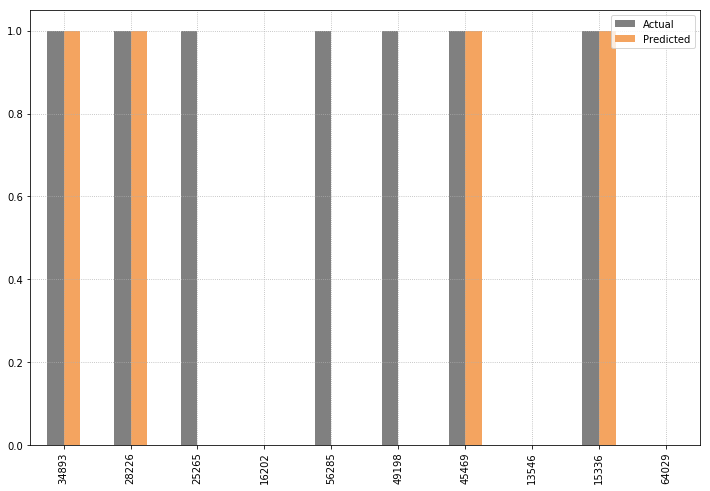

In [25]:
Actual_pred_df.plot(kind='bar',figsize=(12,8), color=['gray', 'sandybrown',])
plt.grid(linestyle=':', linewidth='0.8')
plt.show()

We used the rounded values as this can show a more clear indicaition on accuracy

In [26]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.38683258609023713
Root Mean Squared Error: 0.43749424382604385


MAE and RMSE values 

### Using SVM to predict using Activity and Cholestrol levels

In [27]:
from sklearn import svm
from sklearn.model_selection import train_test_split
cardio = df.cardio
X_train, X_test, y_train, y_test = train_test_split(df[['cholesterol','active']], cardio, test_size=0.3, random_state=42)
print('X train size ==>', X_train.shape)
print('Y train size ==>', y_train.shape)
print('X test size ==>', X_test.shape)
print('Y test size ==>', y_test.shape)

X train size ==> (42099, 2)
Y train size ==> (42099,)
X test size ==> (18043, 2)
Y test size ==> (18043,)


Now we are going to use SVM to predict CVD through training and testing

In [28]:
#add comments
df_clf = svm.SVC(kernel='linear')
df_clf.fit(X_train, y_train)
df_predict = df_clf.predict(X_test)
pd.DataFrame({'Cholesterol': X_test['cholesterol'], 'active': X_test['active'],  'Predicted': df_predict}).head(20)


,Cholesterol,active,Predicted
36580,1,0,0
62337,3,0,1
22383,1,0,0
59978,1,0,0
39656,1,1,0
20685,1,1,0
50820,1,0,0
44525,1,0,0
64415,1,1,0
64951,1,1,0


Table shows SVM predicting whether the patient has CVD based on his Cholesterol and Active levels. As previously noted this further proves the result gathered from linear regression that showed a relation between cholesterol levels and CVD

In [29]:
#add comments
print('Accuracy :', metrics.accuracy_score(y_test, df_predict))
print('Precision :', metrics.precision_score(y_test, df_predict))
print('Recall :', metrics.recall_score(y_test, df_predict))

Accuracy : 0.5855456409687968
Precision : 0.6565749942223249
Recall : 0.32163477867089324
